# Часть 2. Предобработка датасета `Krasnodar`

## Add description!!!

## 1. Exploring the data

#### 1.1. Импортируем нужные инструменты.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
# displaying all the columns

#### 1.2. Краткий обзор данных.

In [2]:
data = pd.read_csv('krasnodar.csv', low_memory = False)

In [3]:
display(data.columns)
display(data.shape)

Index(['id', 'first_name', 'full_name', 'email', 'phone_number',
       'address_city', 'address_street', 'address_house', 'address_entrance',
       'address_floor', 'address_office', 'address_comment',
       'location_latitude', 'location_longitude', 'amount_charged', 'user_id',
       'user_agent', 'created_at', 'address_doorcode'],
      dtype='object')

(164538, 19)

## 2. Preprocessing

**Этапы:**

1. *Обработка столбцов*
2. *Обработка дубликатов*
3. *Обработка пропусков*
4. *Аномальные значения*

#### 2.1. Обработка столбцов.

1. Удалим ненужные столбцы
2. Посмотрим на типы данных в столбцах
3. Изменим при необходимости.

In [4]:
data = data.drop(columns = ['full_name', 'email', 'phone_number',
                         'address_comment', 'address_doorcode', 'location_latitude',
                         'location_longitude', 'user_id', 'first_name', 'address_house',
                         'address_entrance', 'address_floor', 'address_office'])

In [5]:
data.dtypes

id                 int64
address_city      object
address_street    object
amount_charged     int64
user_agent        object
created_at        object
dtype: object

*Видим, что `created_at` дата записана в виде `object`, перенесем её в тип `datetime`*

In [6]:
data['created_at'] = pd.to_datetime(data['created_at'])

#### 2.2. Обработка дубликатов.

In [7]:
amount_of_dups = data.duplicated().sum()

if amount_of_dups == 0:
    print('There are no duplicates in the dataset.')
else:
    print(f'There are {amount_of_dups} in the dataset.')

There are no duplicates in the dataset.


In [8]:
print([i for i in data.address_city.unique() if 'посёлок' in i ])

['посёлок городского типа Яблоновский', 'посёлок Берёзовый', 'посёлок Российский', 'посёлок Южный', 'коттеджный посёлок Золотой Город', 'посёлок Знаменский', 'посёлок городского типа Энем', 'посёлок Колосистый', 'посёлок городского типа Тлюстенхабль', 'посёлок Лорис', 'посёлок Индустриальный', 'посёлок Перекатный', 'коттеджный посёлок Изумрудный Город', 'коттеджный посёлок Крепость', 'посёлок Пригородный', 'посёлок Краснодарский', 'посёлок Плодородный', 'коттеджный посёлок Бавария', 'коттеджный посёлок Николино Парк', 'коттеджный посёлок Ясенево', 'коттеджный посёлок Зелёная Поляна', 'посёлок городского типа Красная Поляна', 'посёлок Лазурный', 'посёлок Новый', 'коттеджный посёлок Чёрное Море', 'посёлок Кочетинский', 'коттеджный посёлок Малиновка', 'посёлок отделения  3 СКЗНИИСиВ', 'посёлок отделения № 2 СКЗНИИСиВ', 'посёлок Прикубанский', 'коттеджный посёлок Комарово', 'посёлок Краснолит', 'посёлок отделения  2 СКЗНИИСиВ', 'посёлок отделения  4 совхоза Пашковский', 'коттеджный посёлок

In [9]:
print([i for i in data.address_city.unique() if 'поселок' in i ])

['поселок Агроном', 'поселок Новый', 'поселок Плодородный']


*Видим, что есть дубликаты вида `посёлок` и `поселок`.*

In [10]:
dups = ['поселок Агроном', 'поселок Новый', 'поселок Плодородный']
dups_count = data.query('address_city in @dups')['id'].count()
print(f'There are {dups_count} lines including values from dups.')


There are 36 lines including values from dups.


*Всего лишь 36 строк, давайте удалим их.*

*Для начала получим их индексы, а затем удалим с помощью метода `drop()`*

In [11]:
print(f'Shape before dropping the rows {data.shape}.')

dups_index = list(data.query('address_city in @dups').index)

data = data.drop(dups_index, axis = 0)

print(f'Shape after dropping the rows {data.shape}.')

Shape before dropping the rows (164538, 6).
Shape after dropping the rows (164502, 6).


#### 2.3. Обработка пропусков.

In [12]:
data.isna().sum()

id                  0
address_city        0
address_street    186
amount_charged      0
user_agent          0
created_at          0
dtype: int64

*Пропуски есть только в колонке `address_street`, давайте от них избавимся.*

In [13]:
print(f'Shape before dropping the rows {data.shape}.')

data = data.dropna()

print(f'Shape after dropping the rows {data.shape}.')

Shape before dropping the rows (164502, 6).
Shape after dropping the rows (164316, 6).


#### 2.4. Аномальные значения.

*Посмотрим, есть ли в датасете заказы с нулевой стоимостью.*

In [14]:
zero_count = data.query('amount_charged == 0')['id'].count()
print(f'There are {zero_count} orders with cost equal to 0.')

conversion = data.query('amount_charged == 0')['id'].shape[0] / data.shape[0]
print(f'Free orders - {int(conversion * 100)}% of the data.')

There are 36247 orders with cost equal to 0.
Free orders - 22% of the data.


*Пропущенные значения составляют 22% от датасета, поэтому мы не можем убрать их оттуда. Можно предположить, что это заказы за бонусы, либо ошибка системы. Давайте переместим их в отдельный датасет.* 

In [15]:
data = data.query('amount_charged != 0')

data_zero_orders = data.query('amount_charged == 0')

*Проверим аномальные значения колонки `amount_charged`. Построим распределения `distplot` и `boxplot`.*

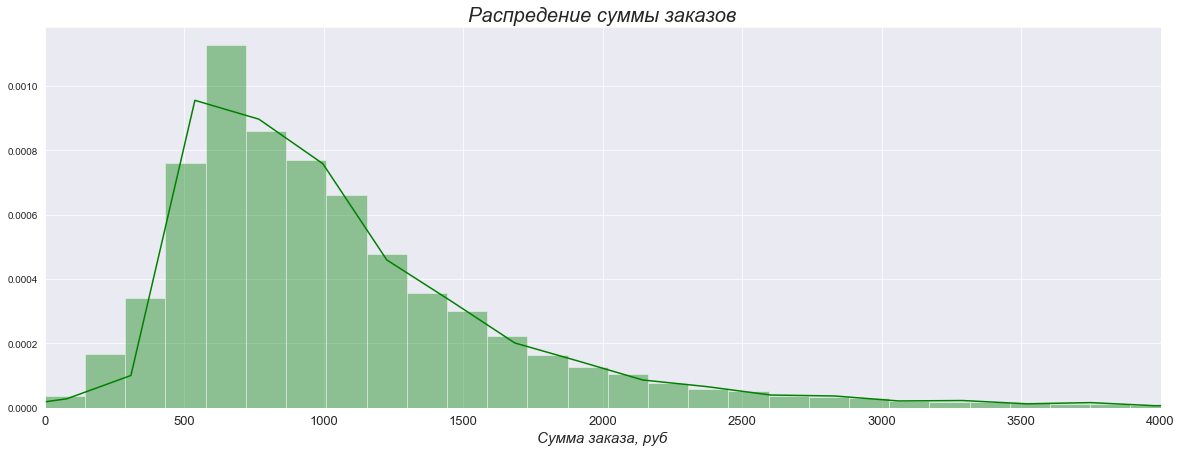

In [16]:
plt.figure(figsize = (20,7))
sns.set_style('darkgrid')

sns.distplot(data['amount_charged'], bins = 200,  color = 'g')

plt.title('Распредение суммы заказов', size = 20, style = 'italic')
plt.xlabel('Сумма заказа, руб', size = 15, style = 'italic')

plt.xticks(range(0,30001,500), size = 13)
plt.xlim([0,4000])


plt.show()

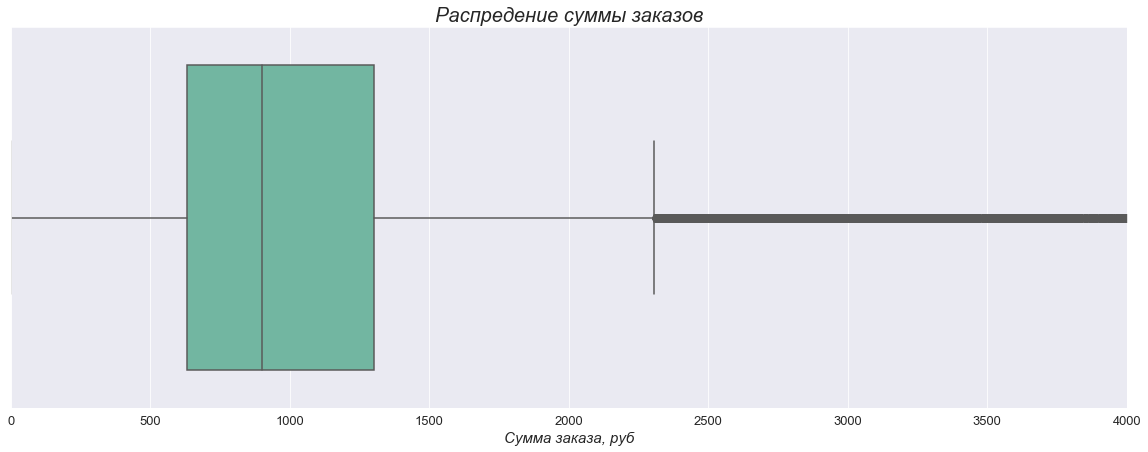

count    128069
mean       1088
std         782
min           1
25%         631
50%         899
75%        1301
90%        1883
95%        2412
99%        4014
max       28824
Name: amount_charged, dtype: int32

In [17]:
plt.figure(figsize = (20,7))
sns.set_style('darkgrid')

sns.boxplot(data['amount_charged'], palette = 'Set2')

plt.title('Распредение суммы заказов', size = 20, style = 'italic')
plt.xlabel('Сумма заказа, руб', size = 15, style = 'italic')

plt.xticks(range(0,30001,500), size = 13)
plt.xlim([0,4000])

plt.show()

display(data['amount_charged'].describe(percentiles = [.25, .50, .75, .90, .95, .99]).astype(int))

 *Видим, что 99% заказов делают на сумму до 4000 рублей.*

*Убёрем аномальные значения из основного датасета и запишем большие заказы в отдельный датасет, быть может они нам понадобятся.*



In [18]:
data = data.query('amount_charged <= 4000')

data_big_orders = data.query('amount_charged > 4000')

## 3. Категоризация данных по параметрам

**Проведем категоризацию данных, будем категоризировать по нескольким параметрам:**

1. *По сумме заказа*
2. *По времени заказа*

#### 3.1. Сумма заказа
*Сделаем несколько категорий:*

1. Маленькие заказы - до 300р.
2. Средние заказы - до 1000р.
3. Большие заказы - до 2000р.
4. Очень большие заказы - от 2000р.

In [43]:
def cat_amount_charged(row):
    if row < 300:
        return 'small'
    elif row < 1000:
        return 'average'
    elif row < 2000:
        return 'big'
    else:
        return 'huge'
    return 'no_category'

In [44]:
data['cost_category'] = data['amount_charged'].apply(cat_amount_charged)

#### 3.2. Время заказа
*Сделаем несколько категорий:*

1. Месяц заказа.
2. День недели заказа.
3. Час заказа.

In [45]:
data['month_date'] = data['created_at'].dt.month
data['day_date'] = data['created_at'].dt.day_name()
data['hour_date'] = data['created_at'].dt.hour